In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patchworklib as pw
import seaborn as sns
import xarray as xr
from data_utils import get_gfp_peaks
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding
from sklearn.metrics import accuracy_score
from tqdm import tqdm

plt.style.use("papers")
plt.rcParams.update(
    {
        "axes.facecolor": "white",
        "figure.facecolor": "white",
        "savefig.facecolor": "white",
    }
)
pw.overwrite_axisgrid()

FOLDER = "../../results/20220914_random_data_stuff_200subjects_20channels_4states_hmm_GFP_no_envelope_PCA"

<Figure size 72x72 with 0 Axes>

In [2]:
data = pd.read_csv(
    os.path.join(FOLDER, "data_and_segmentation.csv"), index_col=[0, 1]
).rename(columns={"kmeans": "mod. K-Means"})
stats = pd.read_csv(os.path.join(FOLDER, "basic_stats.csv"), index_col=0)
dynstats = pd.read_csv(os.path.join(FOLDER, "dyn_stats.csv"), index_col=0)
maps = xr.open_dataarray(os.path.join(FOLDER, "topomaps.nc"))

In [3]:
COLUMNS_ORDER = [
    "AAHC",
    "TAAHC",
    "mod. K-Means",
    "HMM",
    "PCA",
    "ICA",
]
data_for_corr = data.iloc[:, 20:].loc[:, COLUMNS_ORDER]
data_for_corr = data_for_corr.groupby("subject").corr("spearman").unstack()

In [4]:
segm_df = data.iloc[:, 20:].loc[:, COLUMNS_ORDER]
segm_df.columns.name = "algorithm"

In [5]:
# data.iloc[:, 20:].loc[:, COLUMNS_ORDER].groupby("subject").corr(
#     "spearman"
# ).unstack().mean()
def acc(x, y):
    nans = x.isna() | y.isna()
    x = x[~nans]
    y = y[~nans]
    return accuracy_score(x, y)


accs = []
for subj, df_ in segm_df.groupby("subject"):
    acc_ = df_.apply(lambda x: df_.apply(lambda y: acc(x, y)))
    acc_["subject"] = subj
    # print(acc_)
    acc_ = acc_.reset_index().set_index(["subject", "algorithm"])
    accs.append(acc_)
segm_acc = pd.concat(accs, axis=0).unstack()
segm_acc

algorithm       AAHC                                                TAAHC  \
algorithm       AAHC     HMM     ICA     PCA   TAAHC mod. K-Means    AAHC   
subject                                                                     
rnd_subject_0    1.0  0.1960  0.2432  0.3268  0.4636       0.4144  0.4636   
rnd_subject_1    1.0  0.2924  0.1408  0.2268  0.1524       0.4660  0.1524   
rnd_subject_10   1.0  0.2004  0.2100  0.2800  0.1420       0.2480  0.1420   
rnd_subject_100  1.0  0.3036  0.5120  0.3604  0.2284       0.2500  0.2284   
rnd_subject_101  1.0  0.2520  0.2436  0.3220  0.0624       0.1404  0.0624   
...              ...     ...     ...     ...     ...          ...     ...   
rnd_subject_95   1.0  0.2524  0.2932  0.3336  0.4580       0.3464  0.4580   
rnd_subject_96   1.0  0.2492  0.2244  0.1872  0.4004       0.1552  0.4004   
rnd_subject_97   1.0  0.2488  0.1180  0.2624  0.3164       0.1384  0.3164   
rnd_subject_98   1.0  0.2380  0.2232  0.2932  0.1004       0.2504  0.1004   
rnd_subject_99   1.0  0.2560  0.1236  0.1656  0.0768       0.1136  0.0768   

algorithm                                ...     PCA               \
algorithm           HMM     ICA     PCA  ...     ICA  PCA   TAAHC   
subject                                  ...                        
rnd_subject_0    0.2260  0.3896  0.2680  ...  0.2616  1.0  0.2680   
rnd_subject_1    0.2088  0.2968  0.2500  ...  0.3172  1.0  0.2500   
rnd_subject_10   0.2784  0.1996  0.3484  ...  0.1188  1.0  0.3484   
rnd_subject_100  0.2564  0.2268  0.4000  ...  0.4228  1.0  0.4000   
rnd_subject_101  0.2304  0.2580  0.1776  ...  0.2004  1.0  0.1776   
...                 ...     ...     ...  ...     ...  ...     ...   
rnd_subject_95   0.2568  0.2468  0.3372  ...  0.1100  1.0  0.3372   
rnd_subject_96   0.3104  0.3400  0.1476  ...  0.1672  1.0  0.1476   
rnd_subject_97   0.2388  0.2056  0.1964  ...  0.3980  1.0  0.1964   
rnd_subject_98   0.2124  0.2436  0.1700  ...  0.0960  1.0  0.1700   
rnd_subject_99   0.2424  0.1768  0.2332  ...  0.2336  1.0  0.2332   

algorithm                        ICA                                            
algorithm       mod. K-Means    AAHC     HMM  ICA     PCA   TAAHC mod. K-Means  
subject                                                                         
rnd_subject_0         0.1336  0.2432  0.2460  1.0  0.2616  0.3896       0.2632  
rnd_subject_1         0.3608  0.1408  0.2412  1.0  0.3172  0.2968       0.1372  
rnd_subject_10        0.3060  0.2100  0.2392  1.0  0.1188  0.1996       0.2028  
rnd_subject_100       0.5440  0.5120  0.3240  1.0  0.4228  0.2268       0.2652  
rnd_subject_101       0.3340  0.2436  0.2508  1.0  0.2004  0.2580       0.1384  
...                      ...     ...     ...  ...     ...     ...          ...  
rnd_subject_95        0.2184  0.2932  0.2264  1.0  0.1100  0.2468       0.5296  
rnd_subject_96        0.1288  0.2244  0.2540  1.0  0.1672  0.3400       0.3204  
rnd_subject_97        0.2740  0.1180  0.2400  1.0  0.3980  0.2056       0.3832  
rnd_subject_98        0.1452  0.2232  0.2148  1.0  0.0960  0.2436       0.3220  
rnd_subject_99        0.2896  0.1236  0.2112  1.0  0.2336  0.1768       0.3248  

[200 rows x 36 columns]

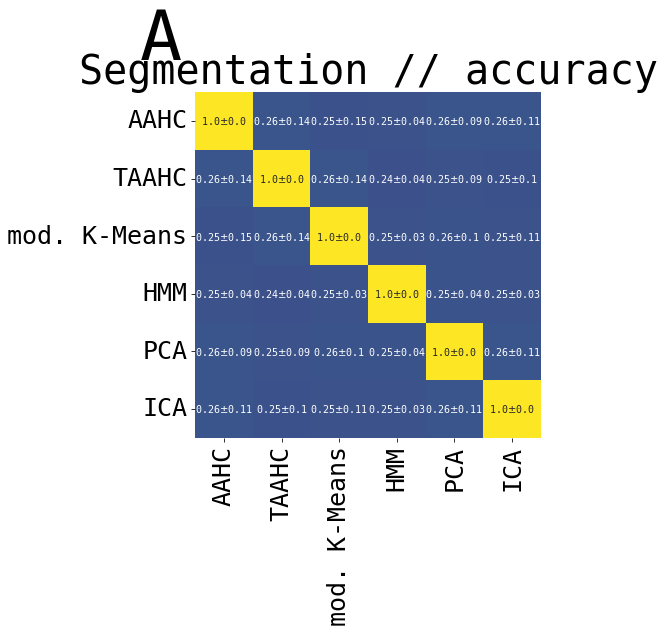

In [6]:
segm_mean = segm_acc.mean().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_mean.index.name = ""
segm_mean.columns.name = ""

segm_std = segm_acc.std().unstack().loc[COLUMNS_ORDER, COLUMNS_ORDER]
segm_std.index.name = ""
segm_std.columns.name = ""

g1 = pw.Brick("ax0", figsize=(6, 6))
sns.heatmap(
    segm_mean,
    square=True,
    vmin=0,
    vmax=1,
    cmap="viridis",
    annot=segm_mean.round(2).astype(str) + "$\pm$" + segm_std.round(2).astype(str),
    fmt="",
    ax=g1,
)
g1.set_title("Segmentation // accuracy")
g1.text(
    -0.1,
    1.15,
    "A",
    ha="center",
    va="center",
    transform=g1.transAxes,
    fontsize=70,
)
g1.savefig(quick=True)
# mean = prep.
# std = prep.std(ddof=1).reset_index().pivot(index="level_0", columns="level_1")

In [7]:
# rcorrs = data[data.columns[3:]].corr("spearman")
# np.fill_diagonal(rcorrs.values, np.nan)
# g7 = pw.Brick("ax54", figsize=(3, 3))
# sns.heatmap(
#     rcorrs,
#     square=True,
#     vmax=1.0,
#     vmin=-1,
#     cmap="bwr",
#     annot=data[data.columns[3:]].rcorr("spearman", padjust="fdr_by", decimals=2),
#     fmt="",
#     annot_kws={"fontsize": 14},
#     ax=g7,
# )
# g7.set_title("Segmentation // Spearman")
# # g7 = pw.load_seaborngrid(g)
# display(data[data.columns[3:]].rcorr("spearman", padjust="fdr_by"))

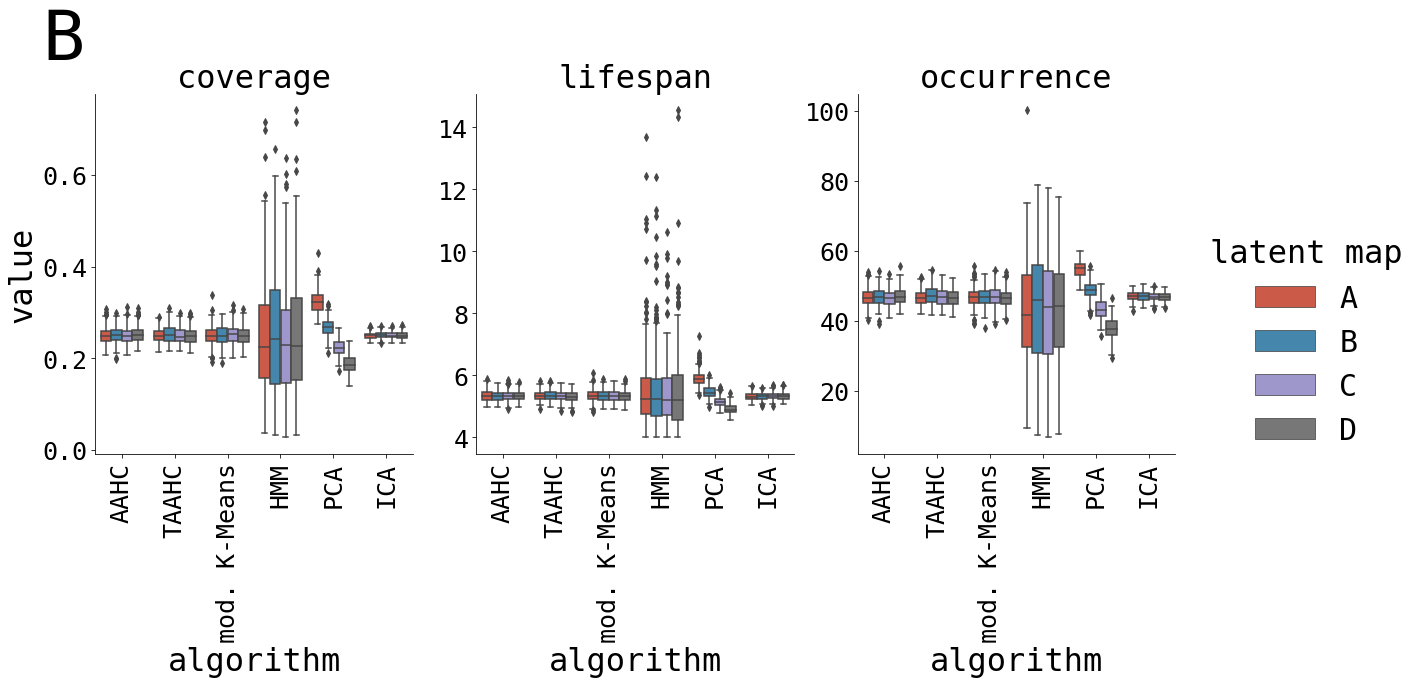

In [8]:
stats = (
    stats.replace({"kmeans": "mod. K-Means"})
    .rename(columns={"var_GFP": "var GFP", "var_total": "var total"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
)
stats_melt = stats.melt(
    id_vars=["algorithm", "latent map"],
    value_vars=["coverage", "lifespan", "occurrence"],
)
g = sns.catplot(
    data=stats_melt,
    x="algorithm",
    y="value",
    hue="latent map",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0][0].text(
    -0.1,
    1.15,
    "B",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g2 = pw.load_seaborngrid(g)
g2.savefig(quick=True)

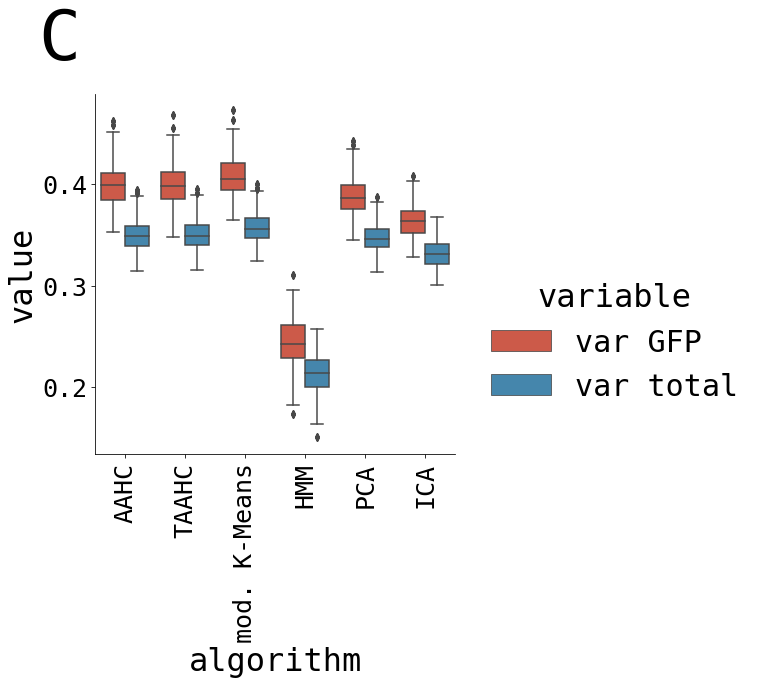

In [9]:
g = sns.catplot(
    data=stats.melt(id_vars="algorithm", value_vars=["var GFP", "var total"]),
    x="algorithm",
    y="value",
    hue="variable",
    kind="box",
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "C",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)

g3 = pw.load_seaborngrid(g)
g3.savefig(quick=True)

In [10]:
dynstats

,algorithm,subject,mixing time,entropy,max entropy,entropy rate,MC entropy rate,AIF 1st peak
0,PCA,rnd_subject_1,1.022184,1.986239,2.0,1.790689,1.984095,40.0
1,ICA,rnd_subject_1,1.017007,1.999441,2.0,1.789982,1.996683,40.0
2,kmeans,rnd_subject_1,1.027437,1.998315,2.0,1.793094,1.994969,36.0
3,AAHC,rnd_subject_1,1.020742,1.998391,2.0,1.794905,1.997253,52.0
4,TAAHC,rnd_subject_1,1.011912,1.998376,2.0,1.791096,1.996184,40.0
...,...,...,...,...,...,...,...,...
1,ICA,rnd_subject_199,0.998520,1.999839,2.0,1.788724,1.998302,56.0
2,kmeans,rnd_subject_199,1.005820,1.995491,2.0,1.787689,1.993111,36.0
3,AAHC,rnd_subject_199,1.040011,1.997931,2.0,1.794021,1.995950,52.0
4,TAAHC,rnd_subject_199,1.025104,1.997500,2.0,1.790671,1.996152,56.0


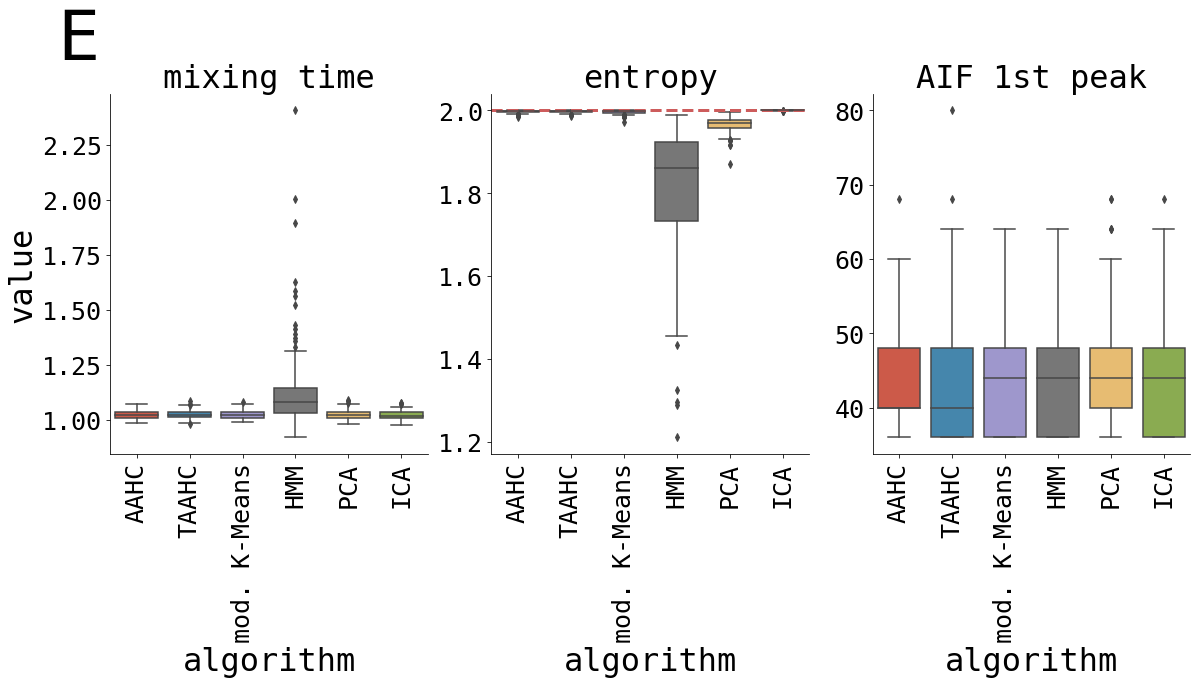

In [11]:
dynstats_melt = (
    dynstats.replace({"kmeans": "mod. K-Means"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["mixing time", "entropy", "AIF 1st peak"],
    )
)
g = sns.catplot(
    data=dynstats_melt,
    x="algorithm",
    y="value",
    col="variable",
    sharex=True,
    sharey=False,
    margin_titles=True,
    kind="box",
)
g.set_xticklabels(rotation=90)
g.set_titles(col_template="{col_name}")
g.axes[0, 1].axhline(
    dynstats["max entropy"].unique()[0],
    linestyle="--",
    color="indianred",
    linewidth=3.0,
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "E",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g4 = pw.load_seaborngrid(g)
g4.savefig(quick=True)

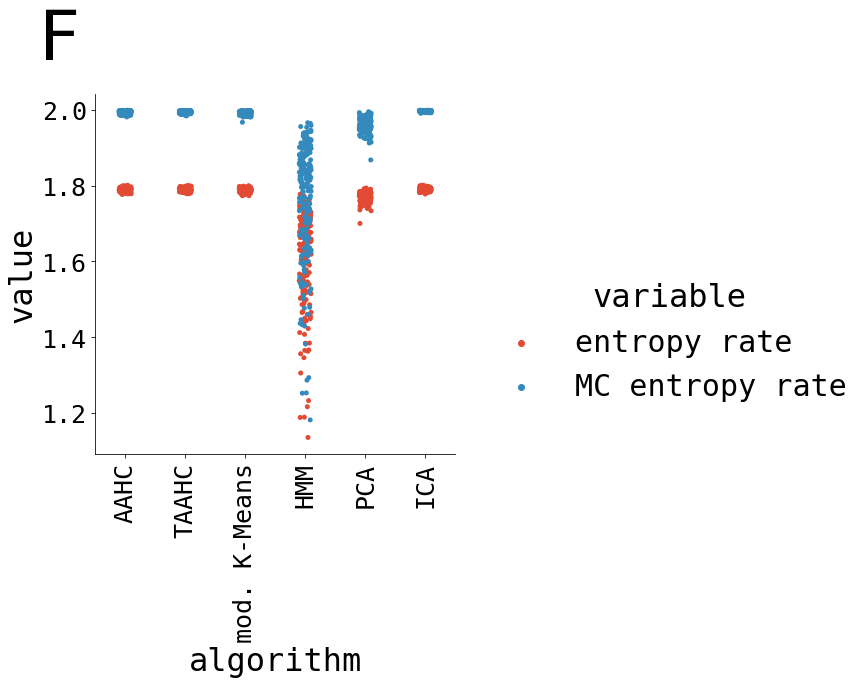

In [12]:
g = sns.catplot(
    data=dynstats.replace({"kmeans": "mod. K-Means"})
    .set_index("algorithm")
    .loc[COLUMNS_ORDER]
    .reset_index()
    .melt(
        id_vars=["algorithm"],
        value_vars=["entropy rate", "MC entropy rate"],
    ),
    x="algorithm",
    y="value",
    hue="variable",
)
g.axes[0][0].text(
    -0.1,
    1.15,
    "F",
    ha="center",
    va="center",
    transform=g.axes[0][0].transAxes,
    fontsize=70,
)
g.set_xticklabels(COLUMNS_ORDER, rotation=90)

g5 = pw.load_seaborngrid(g)
g5.savefig(quick=True)

In [13]:
all_corrs = []
for alg1 in maps["algorithm"]:
    for alg2 in maps["algorithm"]:
        for map1 in maps["latent map"]:
            for map2 in maps["latent map"]:
                corrs = (
                    xr.corr(
                        maps.sel({"algorithm": alg1, "latent map": map1}),
                        maps.sel({"algorithm": alg2, "latent map": map2}),
                        dim="channels",
                    )
                    .assign_coords(
                        {"alg1": alg1, "alg2": alg2, "map1": map1, "map2": map2}
                    )
                    .expand_dims(["alg1", "alg2", "map1", "map2"])
                )
                all_corrs.append(corrs)
all_corrs = np.abs(xr.combine_by_coords(all_corrs))

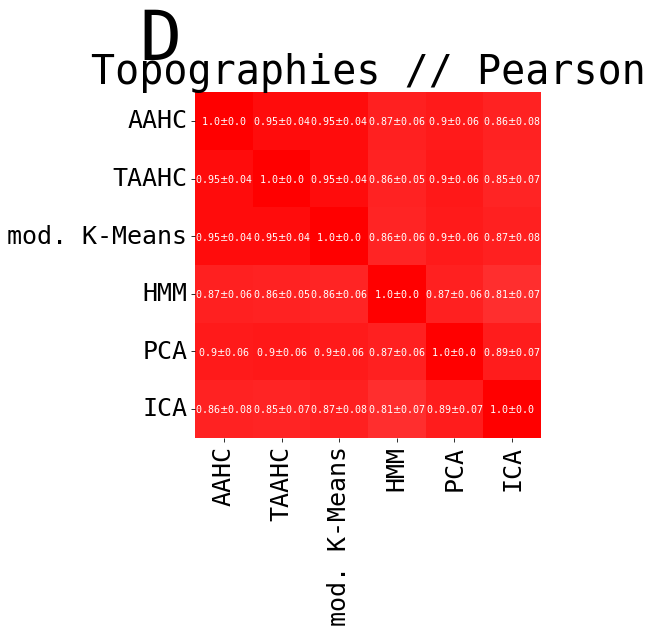

In [14]:
mean = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .mean("subject")
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
mean.index.name = ""
mean.columns = mean.columns.get_level_values(1)
mean.columns.name = ""
mean = mean.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

std = (
    all_corrs.max(["map1", "map2"])
    .stack(algs=("alg1", "alg2"))
    .groupby("algs")
    .std("subject", ddof=1)
    .unstack("algs")
    .to_series()
    .reset_index()
    .pivot(index="alg1", columns="alg2")
)
std.index.name = ""
std.columns = std.columns.get_level_values(1)
std.columns.name = ""
std = std.rename(
    columns={"kmeans": "mod. K-Means"}, index={"kmeans": "mod. K-Means"}
).loc[COLUMNS_ORDER, COLUMNS_ORDER]

g6 = pw.Brick("ax6", figsize=(6, 6))
sns.heatmap(
    mean,
    square=True,
    vmin=-1,
    vmax=1,
    cmap="bwr",
    annot=mean.round(2).astype(str) + "$\pm$" + std.round(2).astype(str),
    fmt="",
    ax=g6,
)
g6.set_title("Topographies // Pearson")
g6.text(
    -0.1,
    1.15,
    "D",
    ha="center",
    va="center",
    transform=g6.transAxes,
    fontsize=70,
)
g6.savefig(quick=True)

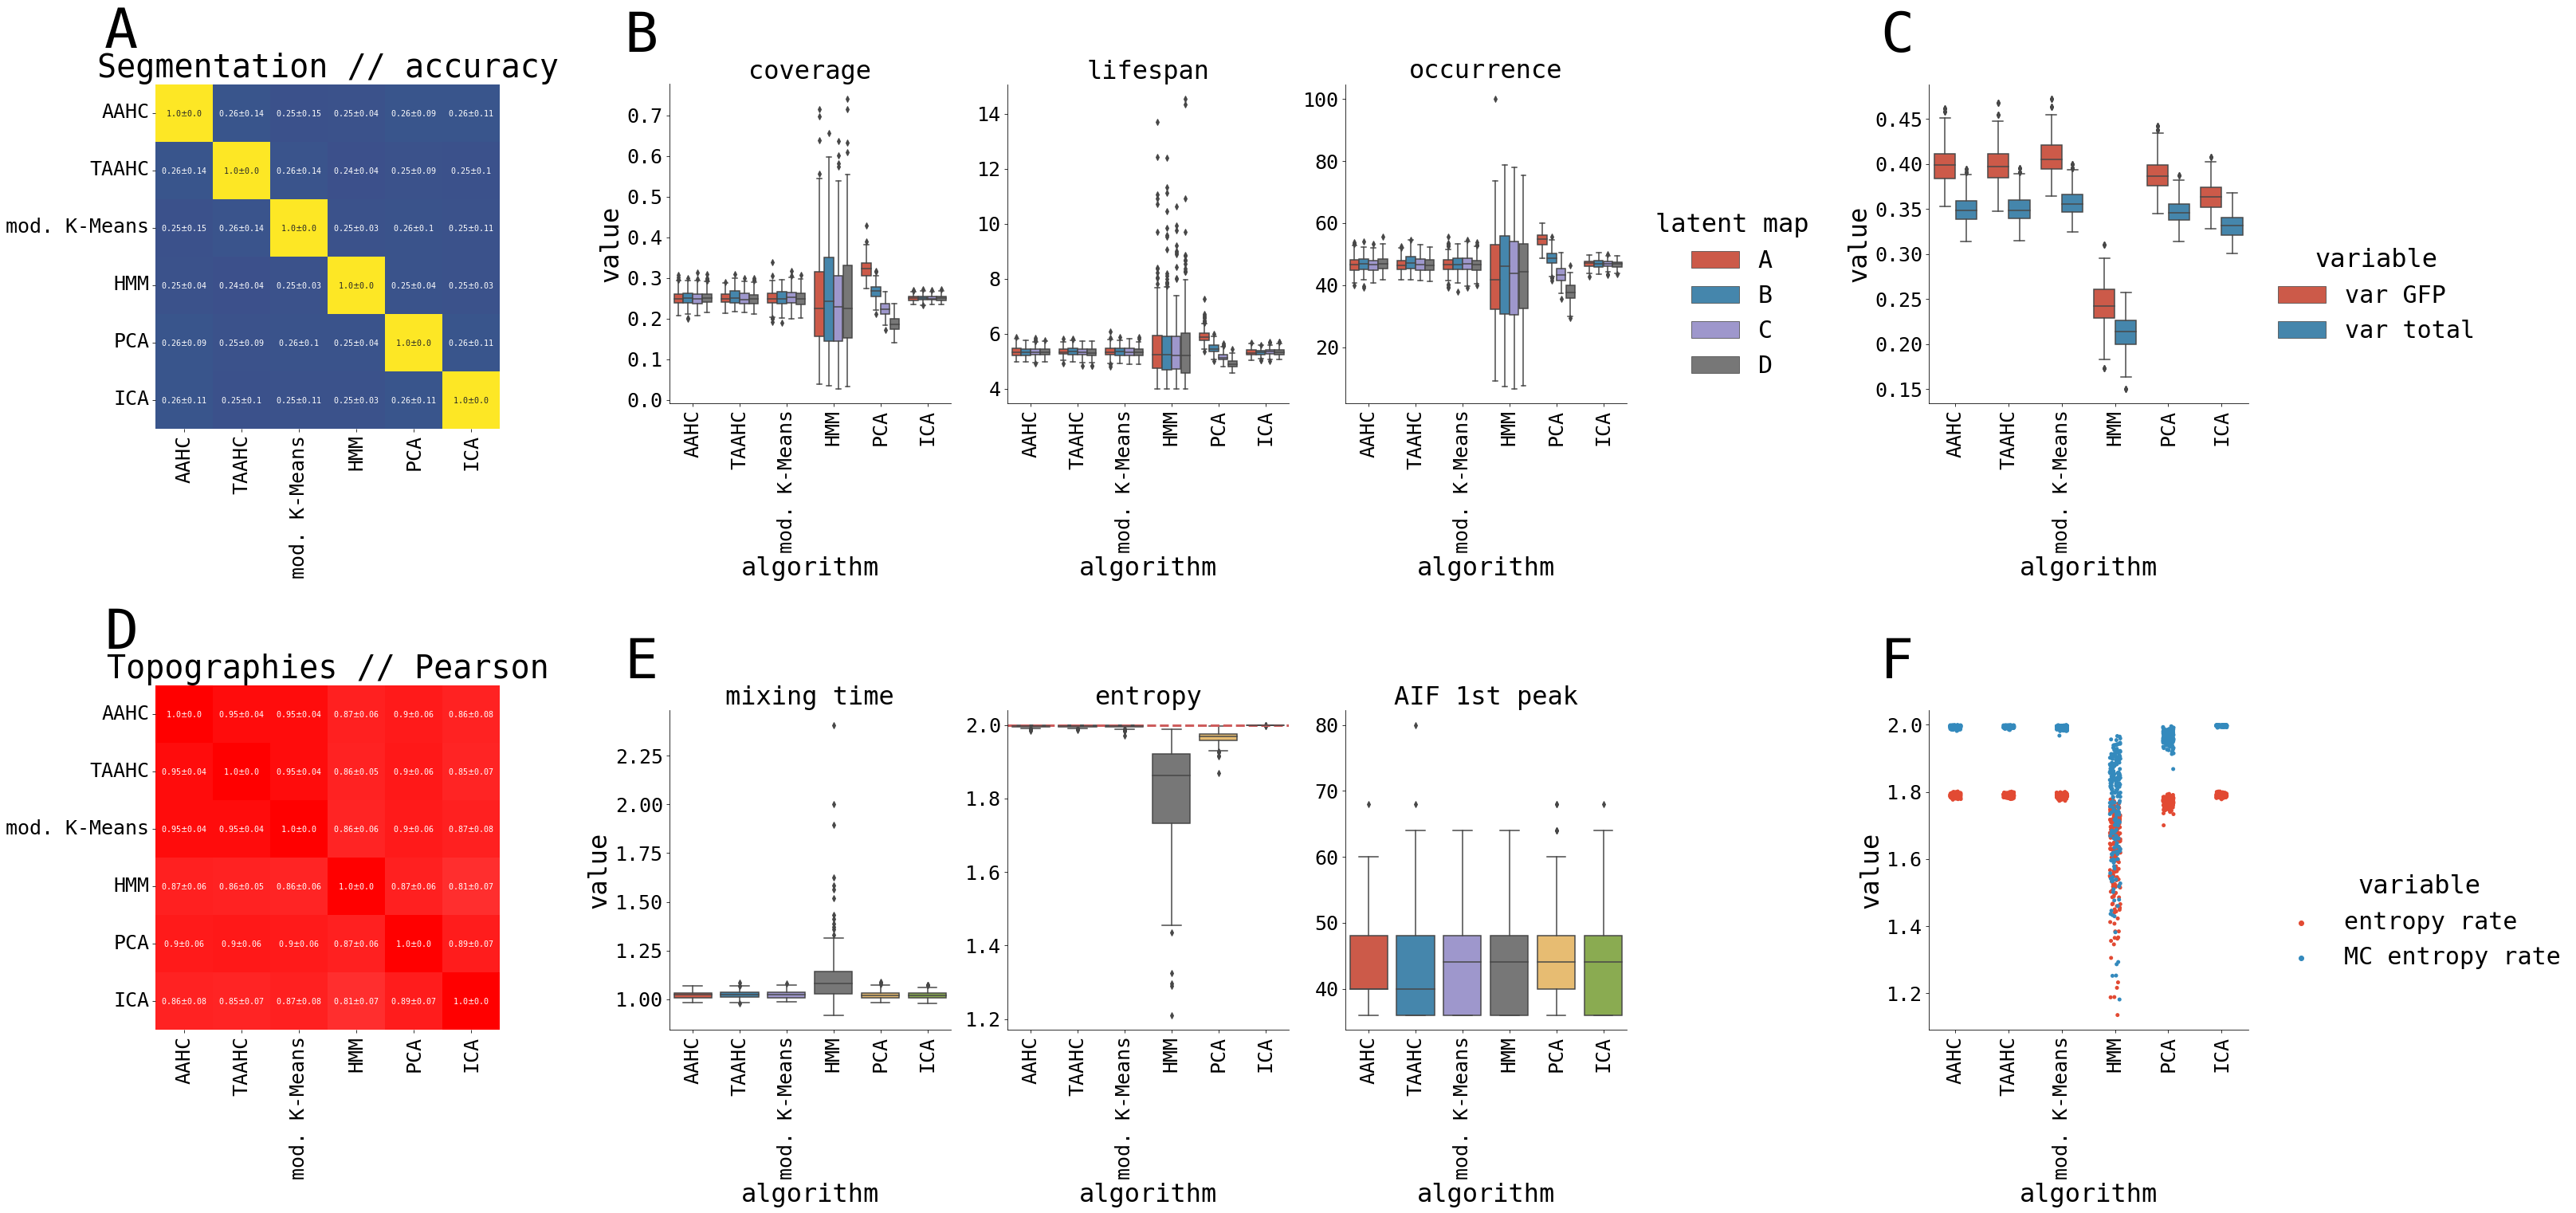

In [15]:
((g1 / g6) | (g2 / g4) | (g3 / g5)).savefig(
    fname="synthetic_subjectwise_stats.pdf", transparent=True
)

In [16]:
mean = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .mean("subject")
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
std = (
    all_corrs.where(all_corrs.alg1 == all_corrs.alg2, drop=True)
    .where(all_corrs.map1 != all_corrs.map2)
    .max(["map1", "map2"])
    .std("subject", ddof=1)
    .to_series()
    .dropna()
    .reset_index()
    .drop("alg2", axis=1)
    .rename(columns={"alg1": "algorithm", 0: "rho"})
    .set_index("algorithm")
)
mean.round(3).astype(str) + " $\pm$ " + std.round(3).astype(str)

,rho
algorithm,
AAHC,0.513 $\pm$ 0.094
HMM,0.709 $\pm$ 0.113
ICA,0.172 $\pm$ 0.06
PCA,0.0 $\pm$ 0.0
TAAHC,0.499 $\pm$ 0.092
kmeans,0.428 $\pm$ 0.1


In [17]:
COLUMNS_ORDER

['AAHC', 'TAAHC', 'mod. K-Means', 'HMM', 'PCA', 'ICA']

In [18]:
RND_SUBJECT = 8
subj_data = data.loc[(f"rnd_subject_{RND_SUBJECT}", slice(None))]
peaks, _ = get_gfp_peaks(
    subj_data.filter(like="chan").values.T,
    min_peak_dist=2,
    smoothing=None,
    smoothing_window=100,
)
subj_data["GFP"] = False
subj_data.iloc[peaks, -1] = True
subj_data

,chan_0,chan_1,chan_2,chan_3,chan_4,chan_5,chan_6,chan_7,chan_8,chan_9,...,chan_17,chan_18,chan_19,PCA,ICA,mod. K-Means,AAHC,TAAHC,HMM,GFP
time,,,,,,,,,,,,,,,,,,,,,
0.000,7.085411,-7.262550,0.380310,-0.801691,0.215470,1.237866,-6.851595,4.865401,-6.061392,2.193713,...,-0.786601,1.386045,5.312649,1,3,2,1,0,0,False
0.004,2.308144,-2.822691,-0.904595,1.415951,-4.777626,3.285214,0.950037,-6.585709,-4.239532,2.258085,...,-0.926987,1.009024,1.546370,0,3,3,2,1,1,False
0.008,-1.737425,3.006613,0.976317,-0.775422,-0.664878,2.302239,-2.460562,10.109169,4.372622,2.683651,...,-0.733138,2.789794,1.235191,3,3,1,3,3,1,False
0.012,-5.845819,1.168157,5.425184,-2.553179,7.279186,-3.825355,0.929216,5.311889,-4.440174,-3.108896,...,-1.717141,2.334480,0.549114,0,3,3,0,1,0,True
0.016,-3.470679,-2.642253,0.879553,3.267260,1.442753,-6.586051,7.337762,-7.092555,5.559704,5.655370,...,3.148749,3.462805,-3.289056,1,1,3,0,0,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.980,5.805505,-4.749052,-4.789992,-5.242003,-2.743577,-2.879723,-0.940748,1.138598,1.440915,1.489131,...,-1.854587,1.796318,-2.535472,0,0,0,2,1,1,False
9.984,1.461811,-2.900594,-2.041042,-0.769854,1.372744,-1.799055,1.911004,-4.659856,-1.176770,0.307559,...,-1.764732,1.948091,-3.062903,3,0,0,3,1,1,False
9.988,8.707458,-1.032503,-0.505464,-2.035233,-4.418436,5.548076,-1.992884,-5.766227,-3.358014,-6.511356,...,-3.966668,5.613575,0.959654,0,0,2,2,1,3,True
